# Attribution Methods Runtime Analysis

This notebook analyzes the runtime performance of different attribution methods across various language models. I explore factors that affect runtime efficiency and provide visualizations to better understand performance characteristics.

## Overview

This analysis focuses on:
1. **Performance comparison** of attribution methods across models
2. **Efficiency metrics** like tokens per second
3. **Hardware impact** on attribution performance
4. **Scaling characteristics** with input length

## Setup and Data Loading


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import re

# Set plotting style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("colorblind")  # Use colorblind-friendly palette

# Set global figure parameters for better readability
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create output directory for plots if it doesn't exist
Path("plots").mkdir(exist_ok=True)

First, let's load the data.


In [2]:
# Load the data files
data_dir = Path("../data")
prompt_timing_df = pd.read_csv(data_dir / "prompt_timing_results.csv")
method_timing_df = pd.read_csv(data_dir / "method_timing_results.csv")
prompt_agg_df = pd.read_csv(data_dir / "prompt_aggregated_results.csv")

# Display basic information about the dataframes
print("Prompt timing dataset information:")
prompt_timing_df.info()

print("\nMethod timing dataset information:")
method_timing_df.info()

print("\nPrompt aggregated dataset information:")
prompt_agg_df.info()

Prompt timing dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   model               600 non-null    object 
 1   attribution_method  600 non-null    object 
 2   prompt_id           600 non-null    object 
 3   token_count         600 non-null    int64  
 4   output_token_count  600 non-null    int64  
 5   attribution_time    600 non-null    float64
 6   tokens_per_second   600 non-null    float64
 7   prompt_text         600 non-null    object 
 8   success             600 non-null    bool   
 9   device              600 non-null    object 
 10  gpu_info            600 non-null    object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 47.6+ KB

Method timing dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column 

In [3]:
# Display sample data from each dataset
print("\nPrompt timing sample:")
display(prompt_timing_df.head(3))

print("\nMethod timing sample:")
display(method_timing_df.head(3))

print("\nPrompt aggregated sample:")
display(prompt_agg_df.head(3))

# Get unique values for key fields
print("\nUnique models:", prompt_timing_df['model'].unique())
print("Unique attribution methods:", prompt_timing_df['attribution_method'].unique())
print("Unique GPU info:", prompt_timing_df['gpu_info'].unique())


Prompt timing sample:


,model,attribution_method,prompt_id,token_count,output_token_count,attribution_time,tokens_per_second,prompt_text,success,device,gpu_info
0,BART,input_x_gradient,prompt_1,20,0,1.983612,10.082617,Answer this yes/no question: do iran and afgha...,True,CUDA,Tesla T4
1,BART,input_x_gradient,prompt_2,22,0,1.426214,15.425458,Answer this yes/no question: do good samaritan...,True,CUDA,Tesla T4
2,BART,input_x_gradient,prompt_3,17,0,1.168161,14.552787,Answer this yes/no question: is windows movie ...,True,CUDA,Tesla T4



Method timing sample:


,model,attribution_method,successful_prompts,total_prompts,success_rate,model_loading_time,attribution_time,average_prompt_time,total_time,platform,cpu_model,cpu_cores,memory_gb,gpu_info,cuda_available,mps_available,torch_version
0,BART,input_x_gradient,20,20,100.0,6.689516,25.393927,1.268878,32.090205,Linux,Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz,4,15.41,Tesla T4,True,False,2.6.0+cu124
1,BART,saliency,20,20,100.0,2.070610,21.142313,1.056292,23.217973,Linux,Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz,4,15.41,Tesla T4,True,False,2.6.0+cu124
2,BART,lime,20,20,100.0,1.921795,206.072127,10.302802,207.999392,Linux,Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz,4,15.41,Tesla T4,True,False,2.6.0+cu124



Prompt aggregated sample:


,model,attribution_method,attribution_time_mean,tokens_per_second_mean,token_count_sum,token_count_mean,token_count_std,output_token_count_sum,output_token_count_mean,output_token_count_std
0,BART,attention,0.307287,65.377271,395,19.75,1.773341,0,0.0,0.0
1,BART,input_x_gradient,1.268878,15.761845,395,19.75,1.773341,0,0.0,0.0
2,BART,integrated_gradients,2.028975,9.806979,395,19.75,1.773341,0,0.0,0.0



Unique models: ['BART' 'GPT-2' 'Llama-3-2-1B']
Unique attribution methods: ['input_x_gradient' 'saliency' 'lime' 'integrated_gradients'
 'layer_gradient_x_activation' 'attention']
Unique GPU info: ['Tesla T4' 'NVIDIA H200']


## Exploratory Data Analysis

Let's first understand our dataset by examining its basic statistics, distributions, and relationships between variables.

In [4]:
# Summary statistics of numerical columns across datasets
print("Prompt timing numerical statistics:")
display(prompt_timing_df.describe())

print("\nMethod timing numerical statistics:")
display(method_timing_df.describe())

# Check for missing values across all datasets
print("\nMissing values in prompt timing dataset:")
display(prompt_timing_df.isnull().sum())

print("\nMissing values in method timing dataset:")
display(method_timing_df.isnull().sum())

print("\nMissing values in prompt aggregated dataset:")
display(prompt_agg_df.isnull().sum())

Prompt timing numerical statistics:


,token_count,output_token_count,attribution_time,tokens_per_second
count,600.000000,600.0,600.000000,600.000000
mean,18.540000,0.0,2.081172,28.299581
std,2.008762,0.0,2.956874,34.081517
min,15.000000,0.0,0.095065,1.127074
25%,17.000000,0.0,0.657633,8.945466
50%,18.000000,0.0,1.071021,17.507343
75%,20.000000,0.0,2.065538,29.415931
max,24.000000,0.0,13.721246,207.723135



Method timing numerical statistics:


,successful_prompts,total_prompts,success_rate,model_loading_time,attribution_time,average_prompt_time,total_time,cpu_cores,memory_gb
count,30.0,30.0,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,20.0,20.0,100.0,2.466974,41.636999,2.081172,44.107751,11.200000,124.106000
std,0.0,0.0,0.0,2.936288,59.922306,2.996077,59.744665,5.979275,90.267115
min,20.0,20.0,100.0,0.658561,2.608392,0.130002,3.288395,4.000000,15.410000
25%,20.0,20.0,100.0,0.810977,13.571267,0.677964,14.454394,4.000000,15.410000
50%,20.0,20.0,100.0,1.430683,21.482671,1.073312,24.059201,16.000000,196.570000
75%,20.0,20.0,100.0,1.884275,40.236141,2.011058,41.924689,16.000000,196.570000
max,20.0,20.0,100.0,13.299464,264.537076,13.226037,265.336776,16.000000,196.570000



Missing values in prompt timing dataset:


model                 0
attribution_method    0
prompt_id             0
token_count           0
output_token_count    0
attribution_time      0
tokens_per_second     0
prompt_text           0
success               0
device                0
gpu_info              0
dtype: int64


Missing values in method timing dataset:


model                  0
attribution_method     0
successful_prompts     0
total_prompts          0
success_rate           0
model_loading_time     0
attribution_time       0
average_prompt_time    0
total_time             0
platform               0
cpu_model              0
cpu_cores              0
memory_gb              0
gpu_info               0
cuda_available         0
mps_available          0
torch_version          0
dtype: int64


Missing values in prompt aggregated dataset:


model                      0
attribution_method         0
attribution_time_mean      0
tokens_per_second_mean     0
token_count_sum            0
token_count_mean           0
token_count_std            0
output_token_count_sum     0
output_token_count_mean    0
output_token_count_std     0
dtype: int64

### Distribution of Models and Attribution Methods

Let's create a clear visualization of how our experiments are distributed across different models and attribution methods.

In [5]:
# Count of experiments by model and attribution method
model_attribution_counts = prompt_timing_df.groupby(['model', 'attribution_method']).size().unstack(fill_value=0)
print("Experiment counts by model and attribution method:")
display(model_attribution_counts)

# Count of tokens processed by model and method
token_counts = prompt_timing_df.groupby(['model', 'attribution_method'])['token_count'].sum().unstack(fill_value=0)
print("\nTotal tokens processed by model and attribution method:")
display(token_counts)

Experiment counts by model and attribution method:


attribution_method,attention,input_x_gradient,integrated_gradients,layer_gradient_x_activation,lime,saliency
model,,,,,,
BART,40,40,40,40,40,40
GPT-2,40,40,40,40,40,40
Llama-3-2-1B,20,20,20,20,20,20



Total tokens processed by model and attribution method:


attribution_method,attention,input_x_gradient,integrated_gradients,layer_gradient_x_activation,lime,saliency
model,,,,,,
BART,790,790,790,790,790,790
GPT-2,710,710,710,710,710,710
Llama-3-2-1B,354,354,354,354,354,354


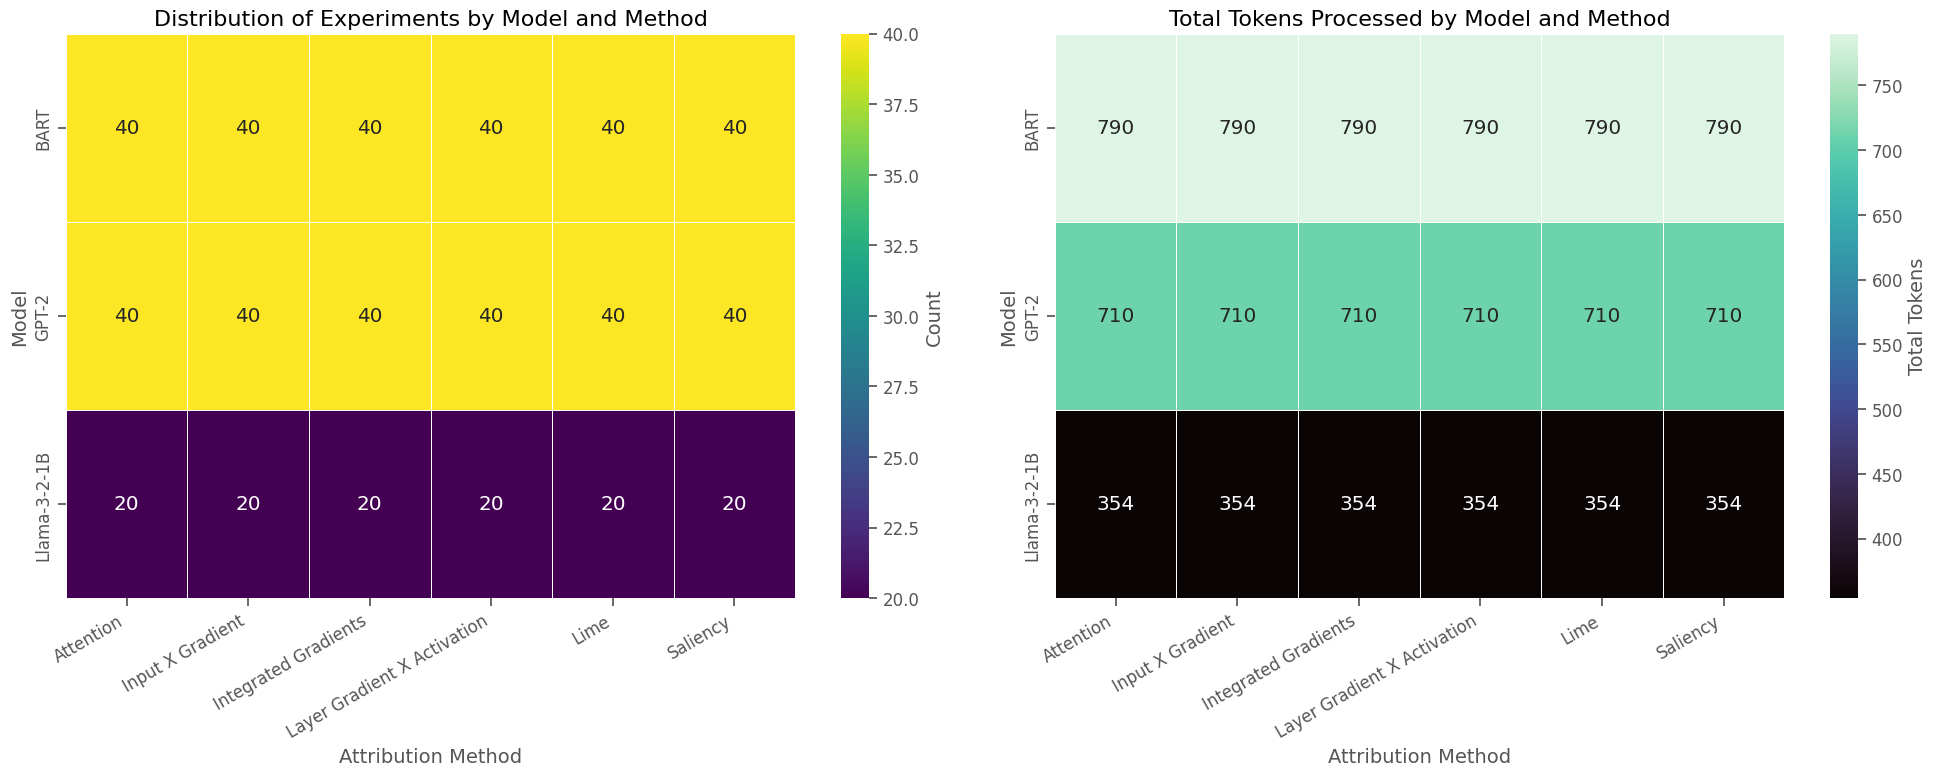

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Heatmap of experiment counts
sns.heatmap(model_attribution_counts, annot=True, fmt='d', cmap='viridis',
            linewidths=.5, cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Distribution of Experiments by Model and Method', fontsize=16)
axes[0].set_xlabel('Attribution Method', fontsize=14)
axes[0].set_ylabel('Model', fontsize=14)

# Plot 2: Heatmap of token counts
sns.heatmap(token_counts, annot=True, fmt='d', cmap='mako',
            linewidths=.5, cbar_kws={'label': 'Total Tokens'}, ax=axes[1])
axes[1].set_title('Total Tokens Processed by Model and Method', fontsize=16)
axes[1].set_xlabel('Attribution Method', fontsize=14)
axes[1].set_ylabel('Model', fontsize=14)

# Improve readability of method names on x-axis
for ax in axes:
    ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()], 
                       rotation=30, ha='right')

plt.tight_layout()
plt.savefig('plots/experiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Runtime Performance Analysis

In this section, we'll analyze the runtime performance across different models and attribution methods. We'll focus on creating clear, insightful visualizations that accurately represent the data patterns.

### 1. Overall Runtime Comparison

First, let's analyze the overall runtime performance of different attribution methods across models.

In [7]:
# Analyze method runtime statistics
# Calculate summary statistics for attribution time
runtime_stats = {
    'prompt_level': prompt_timing_df.groupby(['model', 'attribution_method'])['attribution_time'].agg(['mean', 'median', 'std', 'min', 'max']),
    'method_level': method_timing_df.groupby(['model', 'attribution_method'])['attribution_time'].first(),
    'aggregated': prompt_agg_df.groupby(['model', 'attribution_method'])['attribution_time_mean'].first()
}

# Calculate mean attribution time for each model and method
mean_times = runtime_stats['prompt_level']['mean'].unstack()
print("Mean attribution time (seconds) by individual prompts:")
display(mean_times)

print("\nTotal attribution time per method (seconds):")
display(method_timing_df.pivot_table(index=['model', 'gpu_info'], columns='attribution_method', values='attribution_time'))

Mean attribution time (seconds) by individual prompts:


attribution_method,attention,input_x_gradient,integrated_gradients,layer_gradient_x_activation,lime,saliency
model,,,,,,
BART,0.238327,1.082112,1.301833,1.043156,7.812243,0.882292
GPT-2,0.199949,1.061630,1.331423,1.081048,9.859761,0.880875
Llama-3-2-1B,0.385259,2.279412,1.378117,2.188168,0.697605,1.957308



Total attribution time per method (seconds):


attribution_method        attention  input_x_gradient  integrated_gradients  \
model        gpu_info                                                         
BART         NVIDIA H200   3.396571         17.920048             11.504973   
             Tesla T4      6.160433         25.393927             40.595328   
GPT-2        NVIDIA H200   2.608392         16.898299              9.863668   
             Tesla T4      5.413544         25.594858             43.421855   
Llama-3-2-1B NVIDIA H200   7.716635         45.600722             27.574141   

attribution_method        layer_gradient_x_activation        lime   saliency  
model        gpu_info                                                         
BART         NVIDIA H200                    17.457725  106.446686  14.178442  
             Tesla T4                       24.297632  206.072127  21.142313  
GPT-2        NVIDIA H200                    16.271729  129.882239  13.440556  
             Tesla T4                       26.999249  264.537076  21.823030  
Llama-3-2-1B NVIDIA H200                    43.775785   13.963400  39.158581

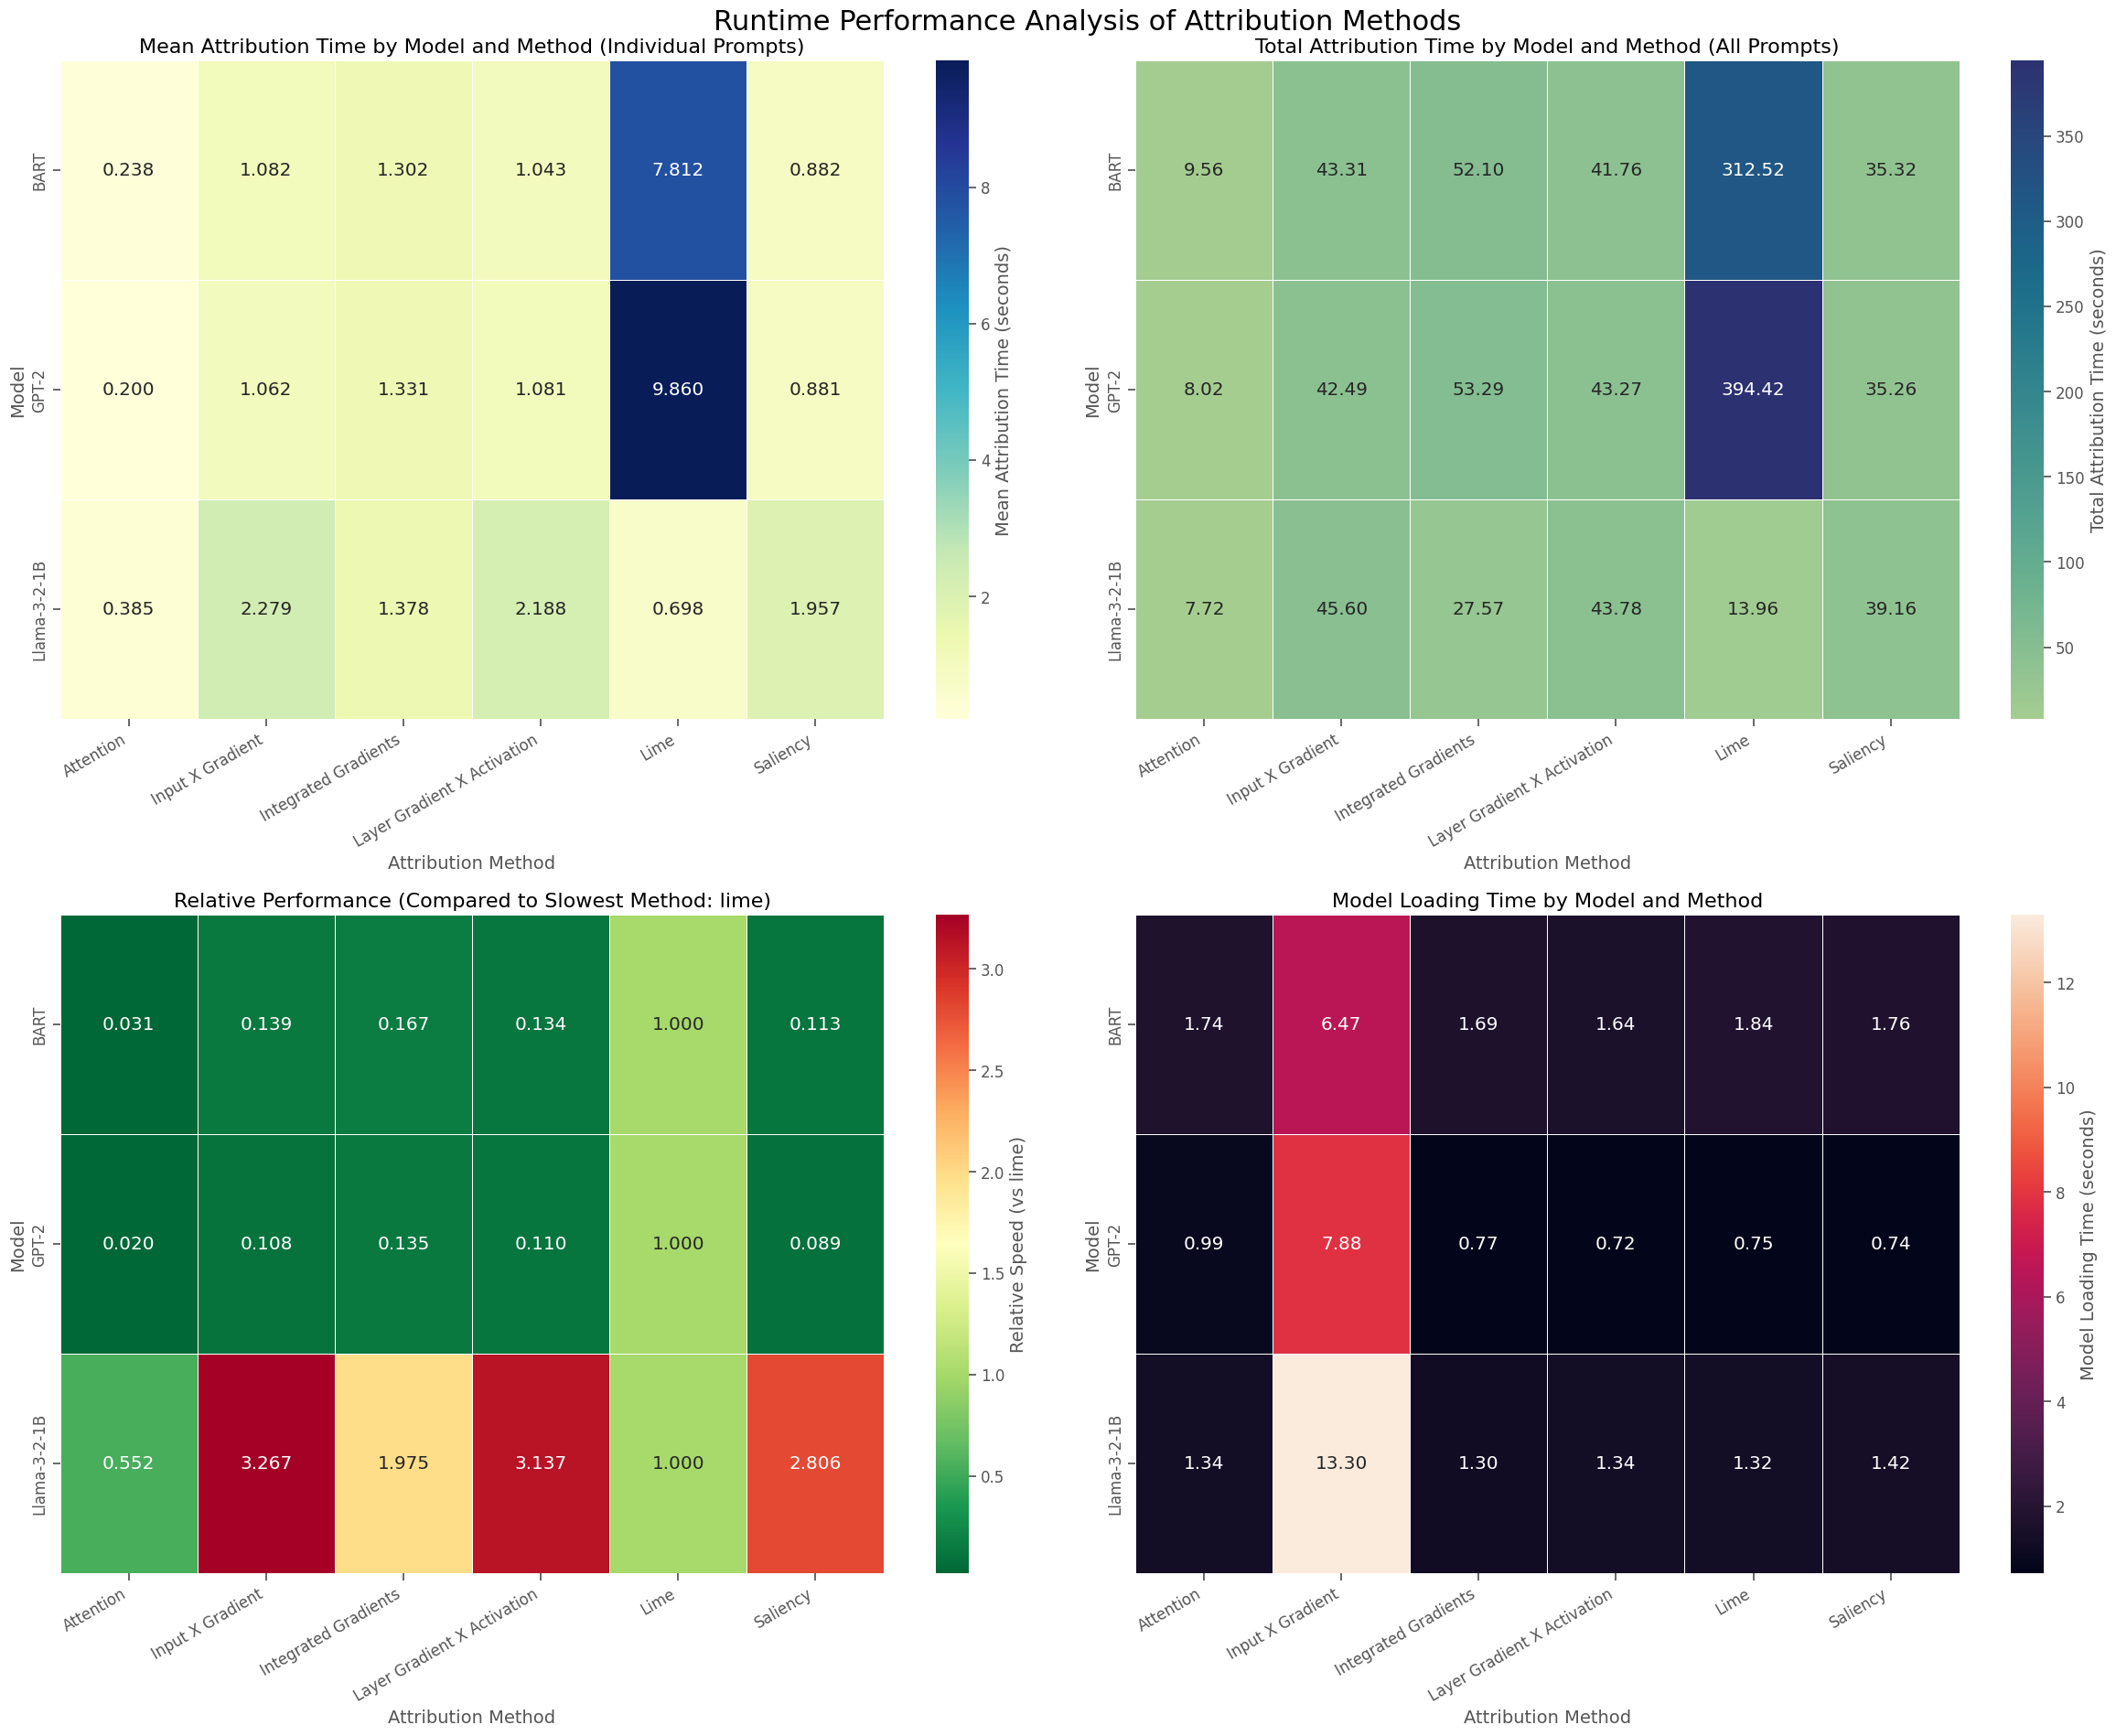

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

# Plot 1: Heatmap of mean attribution times by individual prompts
im1 = sns.heatmap(mean_times, annot=True, fmt='.3f', cmap='YlGnBu',
                 linewidths=0.5, cbar_kws={'label': 'Mean Attribution Time (seconds)'}, ax=axes[0,0])
axes[0,0].set_title('Mean Attribution Time by Model and Method (Individual Prompts)', fontsize=16)
axes[0,0].set_xlabel('Attribution Method', fontsize=14)
axes[0,0].set_ylabel('Model', fontsize=14)

# Plot 2: Heatmap of total attribution times by method
# Use pivot_table instead of pivot to handle duplicate entries
total_times = method_timing_df.pivot_table(index='model', columns='attribution_method', values='attribution_time', aggfunc='sum')
im2 = sns.heatmap(total_times, annot=True, fmt='.2f', cmap='crest',
                 linewidths=0.5, cbar_kws={'label': 'Total Attribution Time (seconds)'}, ax=axes[0,1])
axes[0,1].set_title('Total Attribution Time by Model and Method (All Prompts)', fontsize=16)
axes[0,1].set_xlabel('Attribution Method', fontsize=14)
axes[0,1].set_ylabel('Model', fontsize=14)

# Plot 3: Relative speedup compared to slowest method
slowest_method = mean_times.max().idxmax()
relative_performance = mean_times.div(mean_times[slowest_method], axis=0)
im3 = sns.heatmap(relative_performance, annot=True, fmt='.3f', cmap='RdYlGn_r',
                  linewidths=0.5, cbar_kws={'label': f'Relative Speed (vs {slowest_method})'}, ax=axes[1,0])
axes[1,0].set_title(f'Relative Performance (Compared to Slowest Method: {slowest_method})', fontsize=16)
axes[1,0].set_xlabel('Attribution Method', fontsize=14)
axes[1,0].set_ylabel('Model', fontsize=14)

# Plot 4: Model loading time vs attribution time
model_loading = method_timing_df.pivot_table(index='model', columns='attribution_method', values='model_loading_time', aggfunc='mean')

# Calculate ratio of model loading time to attribution time
# Use pivot_table to handle duplicate entries
ratio_df = method_timing_df.pivot_table(
    index='model', 
    columns='attribution_method', 
    values=['model_loading_time', 'attribution_time'],
    aggfunc='mean'
)

# Calculate the ratio
ratio = ratio_df['model_loading_time'] / ratio_df['attribution_time']

im4 = sns.heatmap(model_loading, annot=True, fmt='.2f', cmap='rocket',
                linewidths=0.5, cbar_kws={'label': 'Model Loading Time (seconds)'}, ax=axes[1,1])
axes[1,1].set_title('Model Loading Time by Model and Method', fontsize=16)
axes[1,1].set_xlabel('Attribution Method', fontsize=14)
axes[1,1].set_ylabel('Model', fontsize=14)

# Improve readability of method names on x-axis for all plots
for ax in axes.flat:
    ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()], 
                       rotation=30, ha='right')

# Add a descriptive text for the whole figure
fig.suptitle('Runtime Performance Analysis of Attribution Methods', fontsize=22, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle
plt.savefig('plots/attribution_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

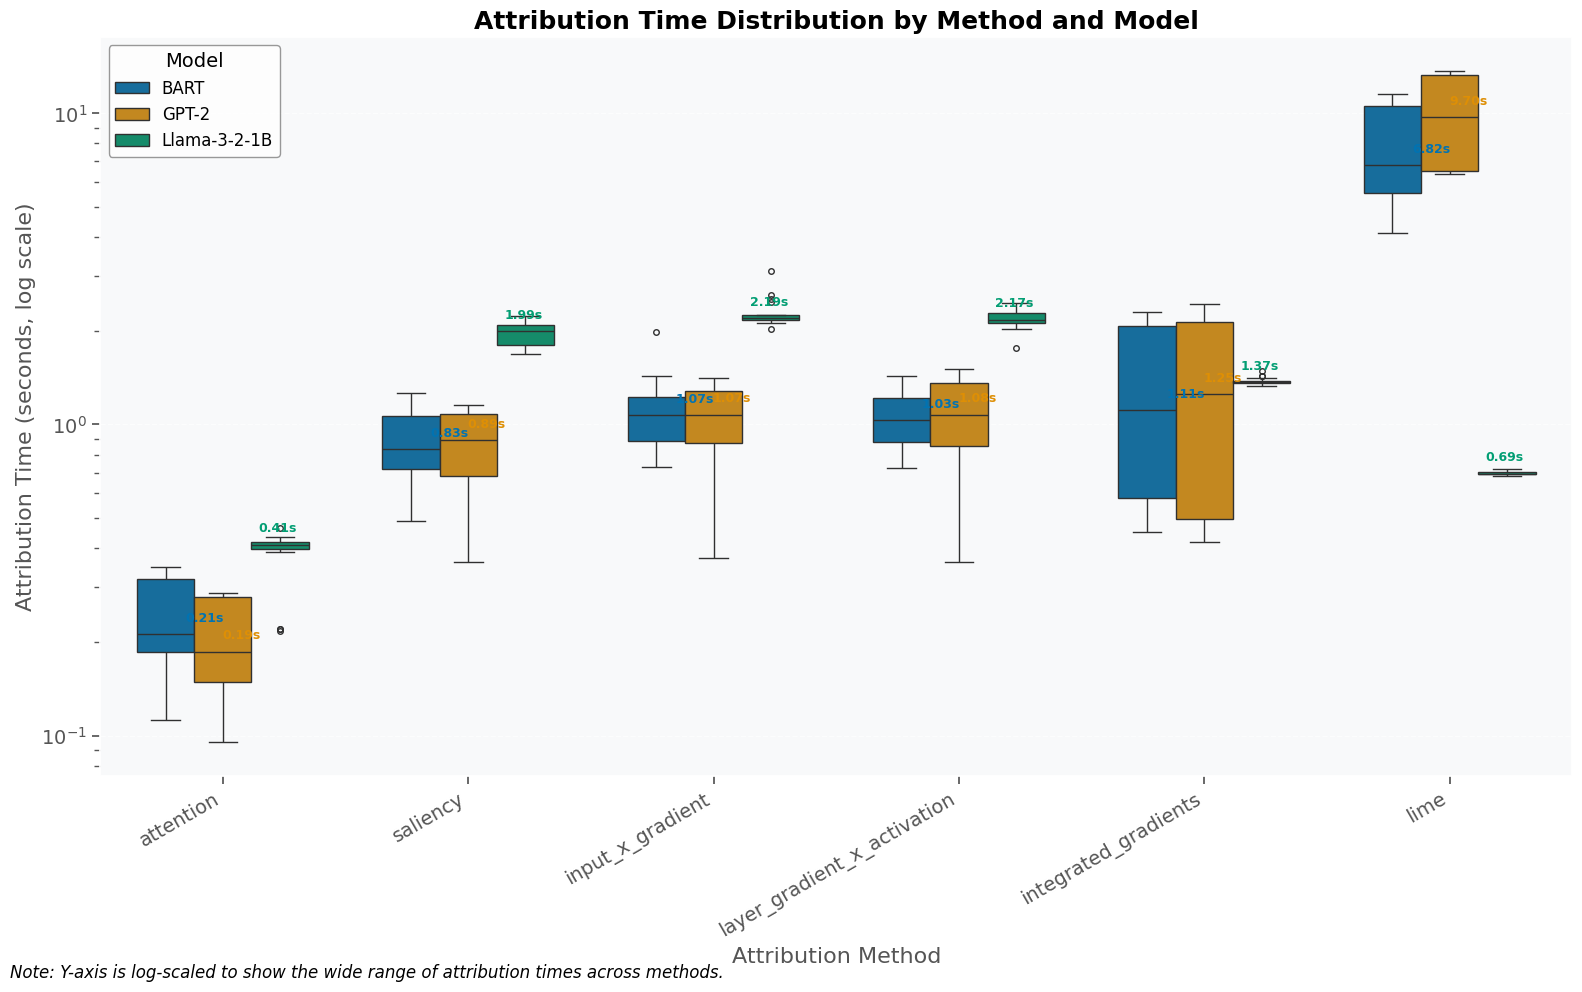

In [9]:
# Prepare data by log-transforming attribution times for better visualization
prompt_timing_df['log_attribution_time'] = np.log10(prompt_timing_df['attribution_time'])

# Sort methods by median attribution time
method_order = prompt_timing_df.groupby('attribution_method')['attribution_time'].median().sort_values().index.tolist()

# Create a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(prompt_timing_df['model'].unique()))

plt.figure(figsize=(16, 10))

# Create main plot with boxplots grouped by attribution method
ax = sns.boxplot(x='attribution_method', y='attribution_time', 
                hue='model', 
                data=prompt_timing_df,
                palette=palette,
                order=method_order,
                width=0.7, 
                fliersize=4)

# Enhance the plot styling
plt.title('Attribution Time Distribution by Method and Model', fontsize=18, fontweight='bold')
plt.xlabel('Attribution Method', fontsize=16)
plt.ylabel('Attribution Time (seconds, log scale)', fontsize=16)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add subtle background color
ax.set_facecolor('#f8f9fa')

# Improve legend
plt.legend(title='Model', title_fontsize=14, fontsize=12,
          frameon=True, facecolor='white', edgecolor='gray')

# Add annotations for key statistics
for i, method in enumerate(method_order):
    for j, model in enumerate(prompt_timing_df['model'].unique()):
        subset = prompt_timing_df[(prompt_timing_df['attribution_method'] == method) & 
                                 (prompt_timing_df['model'] == model)]
        if not subset.empty:
            median = subset['attribution_time'].median()
            # Annotate the median value on each boxplot
            plt.annotate(f"{median:.2f}s", 
                        xy=(i, median), 
                        xytext=(i + (j - 0.5) * 0.15, median * 1.1),
                        fontsize=9, 
                        fontweight='bold', 
                        color=palette[j],
                        ha='center')

# Add descriptive annotation
plt.figtext(0.01, 0.01, 
           "Note: Y-axis is log-scaled to show the wide range of attribution times across methods.", 
           fontsize=12, style='italic')

plt.tight_layout()
plt.savefig('plots/attribution_time_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/2645658609.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()],
/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/2645658609.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()],
/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/2645658609.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()],


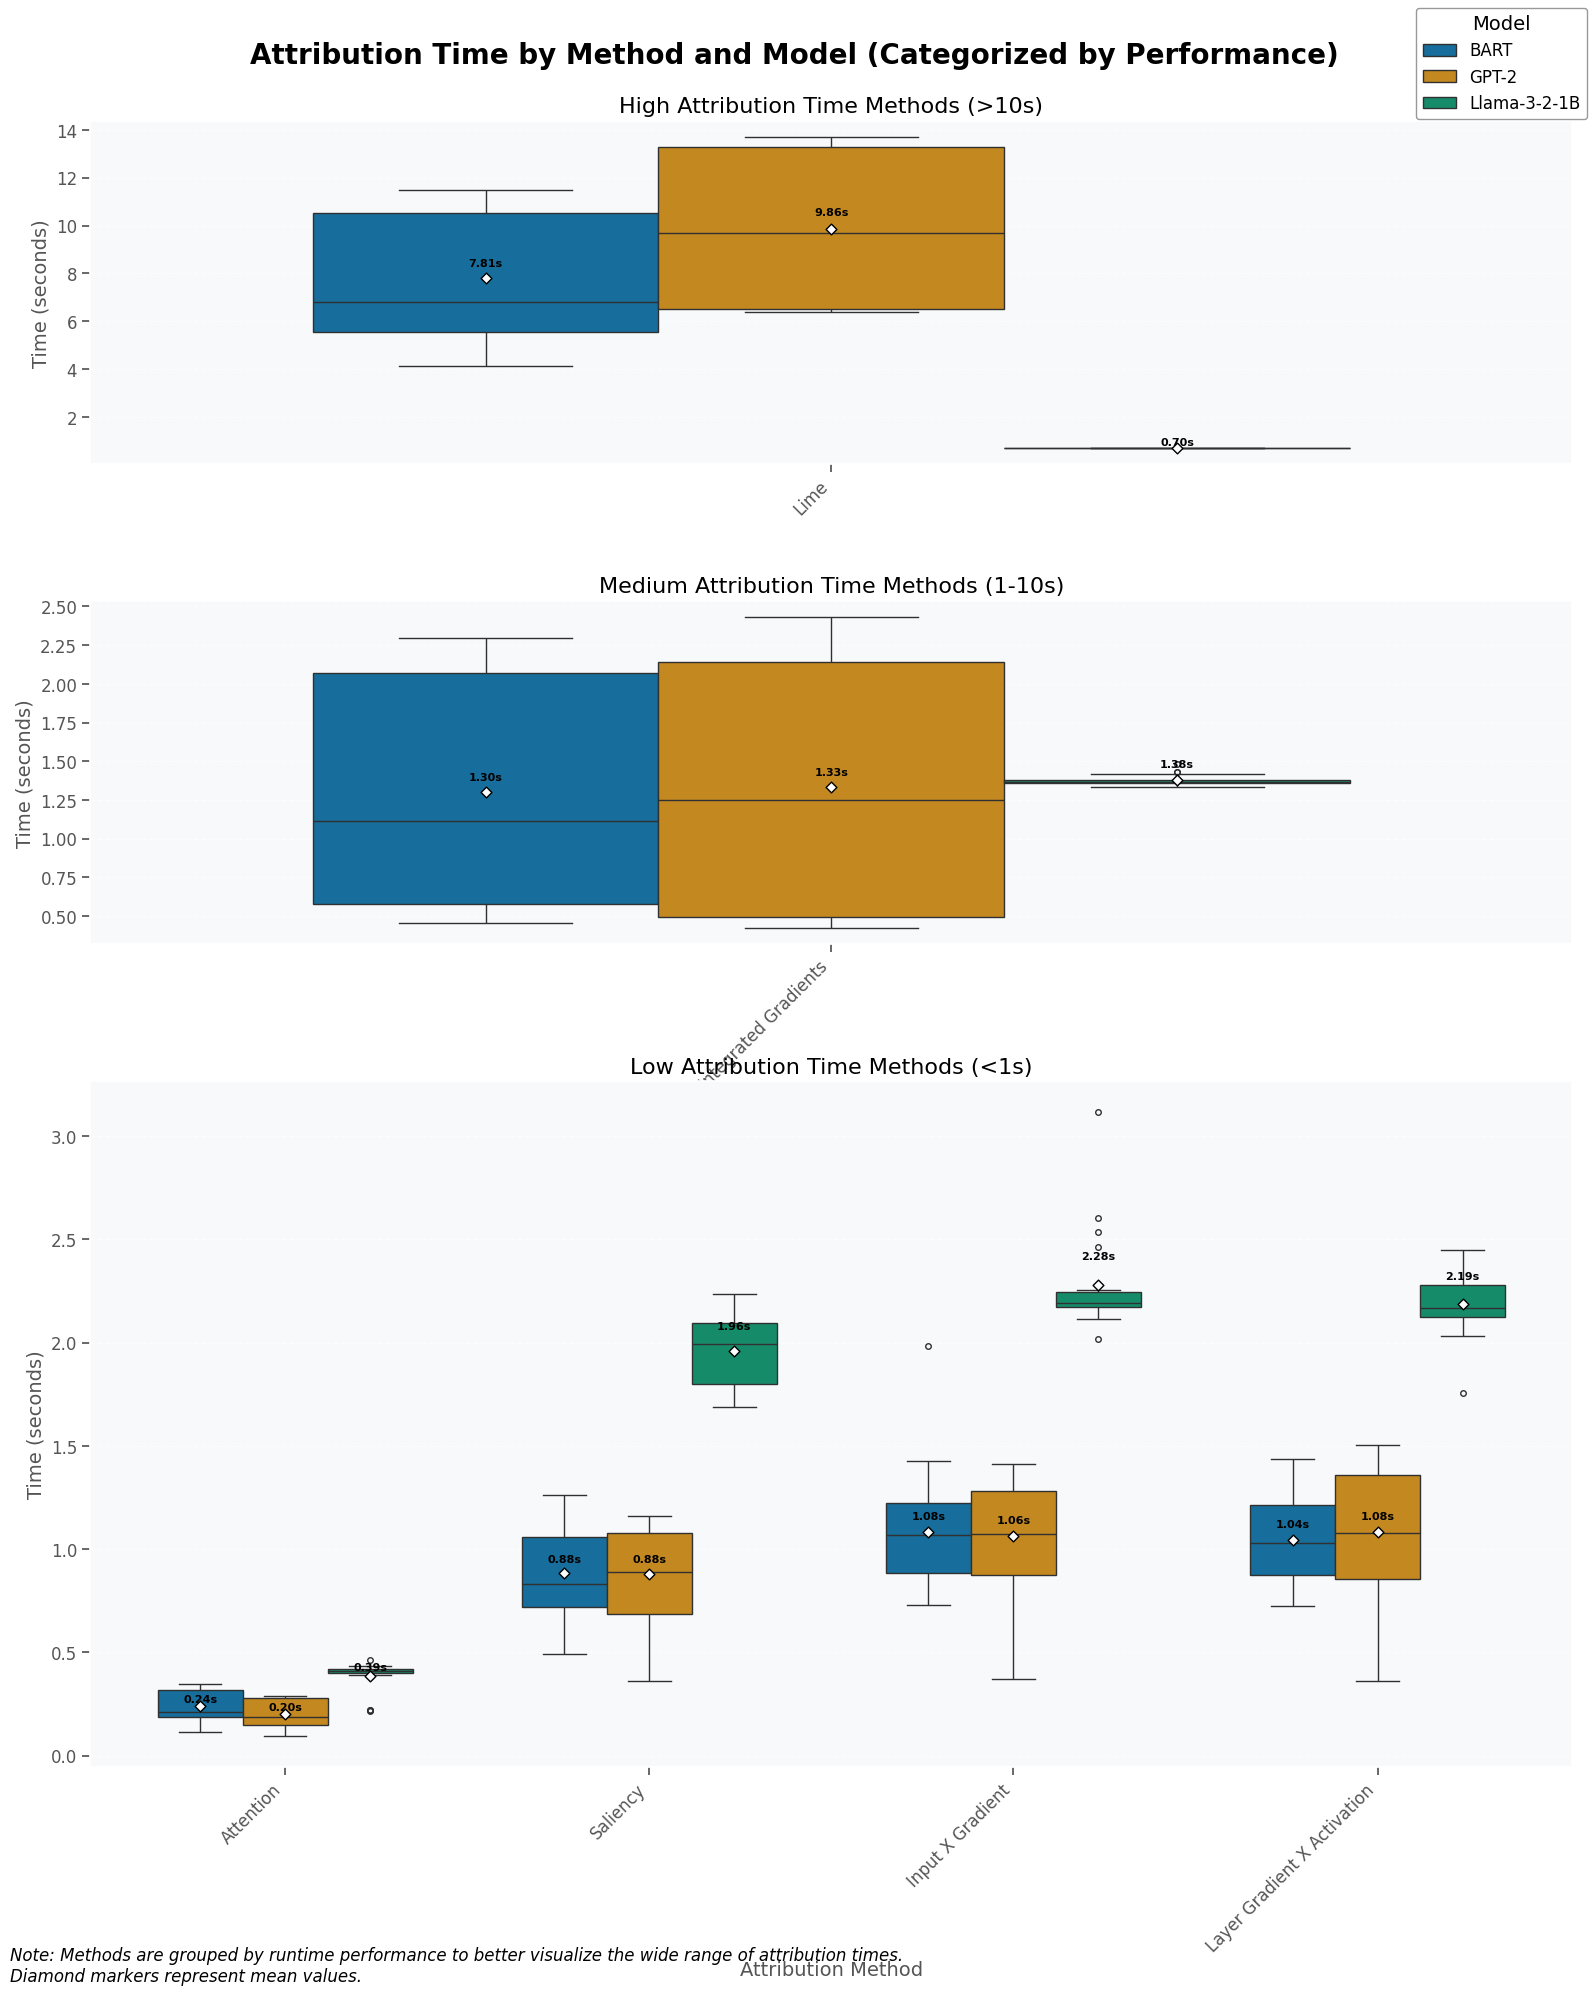

In [16]:
# We also analyse split by method for better overview
# Define method categories based on performance
high_methods = ['lime']  # Extremely slow methods
medium_methods = ['integrated_gradients']  # Medium performance methods
low_methods = [m for m in method_order if m not in high_methods + medium_methods]  # Fast methods

# Filter data for each category
df_high = prompt_timing_df[prompt_timing_df['attribution_method'].isin(high_methods)]
df_medium = prompt_timing_df[prompt_timing_df['attribution_method'].isin(medium_methods)]
df_low = prompt_timing_df[prompt_timing_df['attribution_method'].isin(low_methods)]

# Create figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 20), height_ratios=[1, 1, 2])

# Set colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(prompt_timing_df['model'].unique()))

# Sort methods within each category by median attribution time
high_order = df_high.groupby('attribution_method')['attribution_time'].median().sort_values().index.tolist()
medium_order = df_medium.groupby('attribution_method')['attribution_time'].median().sort_values().index.tolist()
low_order = df_low.groupby('attribution_method')['attribution_time'].median().sort_values().index.tolist()

# Plot 1: High attribution time methods
if not df_high.empty:
    sns.boxplot(x='attribution_method', y='attribution_time', hue='model',
                data=df_high, palette=palette, width=0.7, fliersize=4,
                order=high_order, ax=axes[0])
    axes[0].set_title('High Attribution Time Methods (>10s)', fontsize=16)
    axes[0].set_ylabel('Time (seconds)', fontsize=14)
    axes[0].set_xlabel('')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].set_axisbelow(True)
    if len(high_methods) == 1:
        # Center the single box
        axes[0].set_xlim(-0.5, 0.5)

# Plot 2: Medium attribution time methods
if not df_medium.empty:
    sns.boxplot(x='attribution_method', y='attribution_time', hue='model',
                data=df_medium, palette=palette, width=0.7, fliersize=4,
                order=medium_order, ax=axes[1])
    axes[1].set_title('Medium Attribution Time Methods (1-10s)', fontsize=16)
    axes[1].set_ylabel('Time (seconds)', fontsize=14)
    axes[1].set_xlabel('')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].set_axisbelow(True)
    if len(medium_methods) == 1:
        # Center the single box
        axes[1].set_xlim(-0.5, 0.5)

# Plot 3: Low attribution time methods
if not df_low.empty:
    sns.boxplot(x='attribution_method', y='attribution_time', hue='model',
                data=df_low, palette=palette, width=0.7, fliersize=4,
                order=low_order, ax=axes[2])
    axes[2].set_title('Low Attribution Time Methods (<1s)', fontsize=16)
    axes[2].set_ylabel('Time (seconds)', fontsize=14)
    axes[2].set_xlabel('Attribution Method', fontsize=14)
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[2].set_axisbelow(True)

# Improve x-axis labels and background for all subplots
for ax in axes:
    ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()],
                      rotation=45, ha='right', fontsize=12)
    ax.set_facecolor('#f8f9fa')
    
    # Add mean values as markers
    if len(ax.patches) > 0:  # Check if plot has data
        methods = [method for method in ax.get_xticklabels()]
        num_models = len(prompt_timing_df['model'].unique())
        
        # Get the method names from the current subplot
        current_methods = []
        for text in ax.get_xticklabels():
            method_name = text.get_text().lower().replace(' ', '_')
            for orig_method in prompt_timing_df['attribution_method'].unique():
                if orig_method.lower() == method_name:
                    current_methods.append(orig_method)
                    break
        
        for i, method in enumerate(current_methods):
            for j, model in enumerate(prompt_timing_df['model'].unique()):
                subset = prompt_timing_df[(prompt_timing_df['attribution_method'] == method) & 
                                         (prompt_timing_df['model'] == model)]
                if not subset.empty:
                    mean_val = subset['attribution_time'].mean()
                    # Handle potential positioning issues for single method plots
                    if len(current_methods) == 1:
                        pos = 0
                    else:
                        pos = i
                    offset = (j - (num_models-1)/2) * (0.7/num_models)
                    ax.scatter(pos + offset, mean_val, color='white', edgecolor='black',
                              marker='D', s=30, zorder=10)
                    # Add text for mean value
                    ax.text(pos + offset, mean_val * 1.05, f"{mean_val:.2f}s",
                          ha='center', va='bottom', fontsize=8, fontweight='bold', color='black')

# Use a single legend for the figure
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    ax.get_legend().remove()
fig.legend(handles, labels, title='Model', title_fontsize=14, fontsize=12,
          loc='upper right', frameon=True, facecolor='white', edgecolor='gray')

# Add a main title to the figure
fig.suptitle('Attribution Time by Method and Model (Categorized by Performance)', 
            fontsize=20, fontweight='bold', y=0.98)

# Add an explanatory note
fig.text(0.01, 0.01, 
        "Note: Methods are grouped by runtime performance to better visualize the wide range of attribution times.\n"
        "Diamond markers represent mean values.", 
        fontsize=12, style='italic')

plt.tight_layout()
fig.subplots_adjust(top=0.94, hspace=0.3)  # Make room for the title
plt.savefig('plots/attribution_time_by_method_categorized.png', dpi=300, bbox_inches='tight')
plt.show()

### 2. Tokens Per Second Analysis

Here we analyze the processing efficiency in terms of tokens processed per second, which is a critical metric for understanding model performance.

In [11]:
# Analyze tokens per second statistics
# Calculate average tokens per second for each model and method
tokens_per_sec_stats = prompt_timing_df.groupby(['model', 'attribution_method'])['tokens_per_second'].agg(['mean', 'median', 'std', 'min', 'max'])
mean_tps = tokens_per_sec_stats['mean'].unstack()
median_tps = tokens_per_sec_stats['median'].unstack()

print("Mean tokens per second:")
display(mean_tps)

print("\nMedian tokens per second:")
display(median_tps)

# Also get data from the aggregated dataset
print("\nMean tokens per second from aggregated dataset:")
display(prompt_agg_df.pivot_table(index='model', columns='attribution_method', values='tokens_per_second_mean', aggfunc='mean'))

Mean tokens per second:


attribution_method,attention,input_x_gradient,integrated_gradients,layer_gradient_x_activation,lime,saliency
model,,,,,,
BART,94.641872,18.973180,22.202684,19.543165,2.833884,23.746783
GPT-2,104.939567,17.842332,22.090021,18.304725,2.036091,21.588402
Llama-3-2-1B,48.329315,7.781801,12.819898,8.114608,25.357148,9.099247



Median tokens per second:


attribution_method,attention,input_x_gradient,integrated_gradients,layer_gradient_x_activation,lime,saliency
model,,,,,,
BART,89.654696,18.098330,20.165511,19.850644,2.698268,23.540929
GPT-2,97.544237,17.324085,19.830997,16.561110,1.986333,20.406386
Llama-3-2-1B,42.821175,7.775590,12.504582,7.898073,24.630015,8.922120



Mean tokens per second from aggregated dataset:


attribution_method,attention,input_x_gradient,integrated_gradients,layer_gradient_x_activation,lime,saliency
model,,,,,,
BART,94.641872,18.973180,22.202684,19.543165,2.833884,23.746783
GPT-2,104.939567,17.842332,22.090021,18.304725,2.036091,21.588402
Llama-3-2-1B,48.329315,7.781801,12.819898,8.114608,25.357148,9.099247


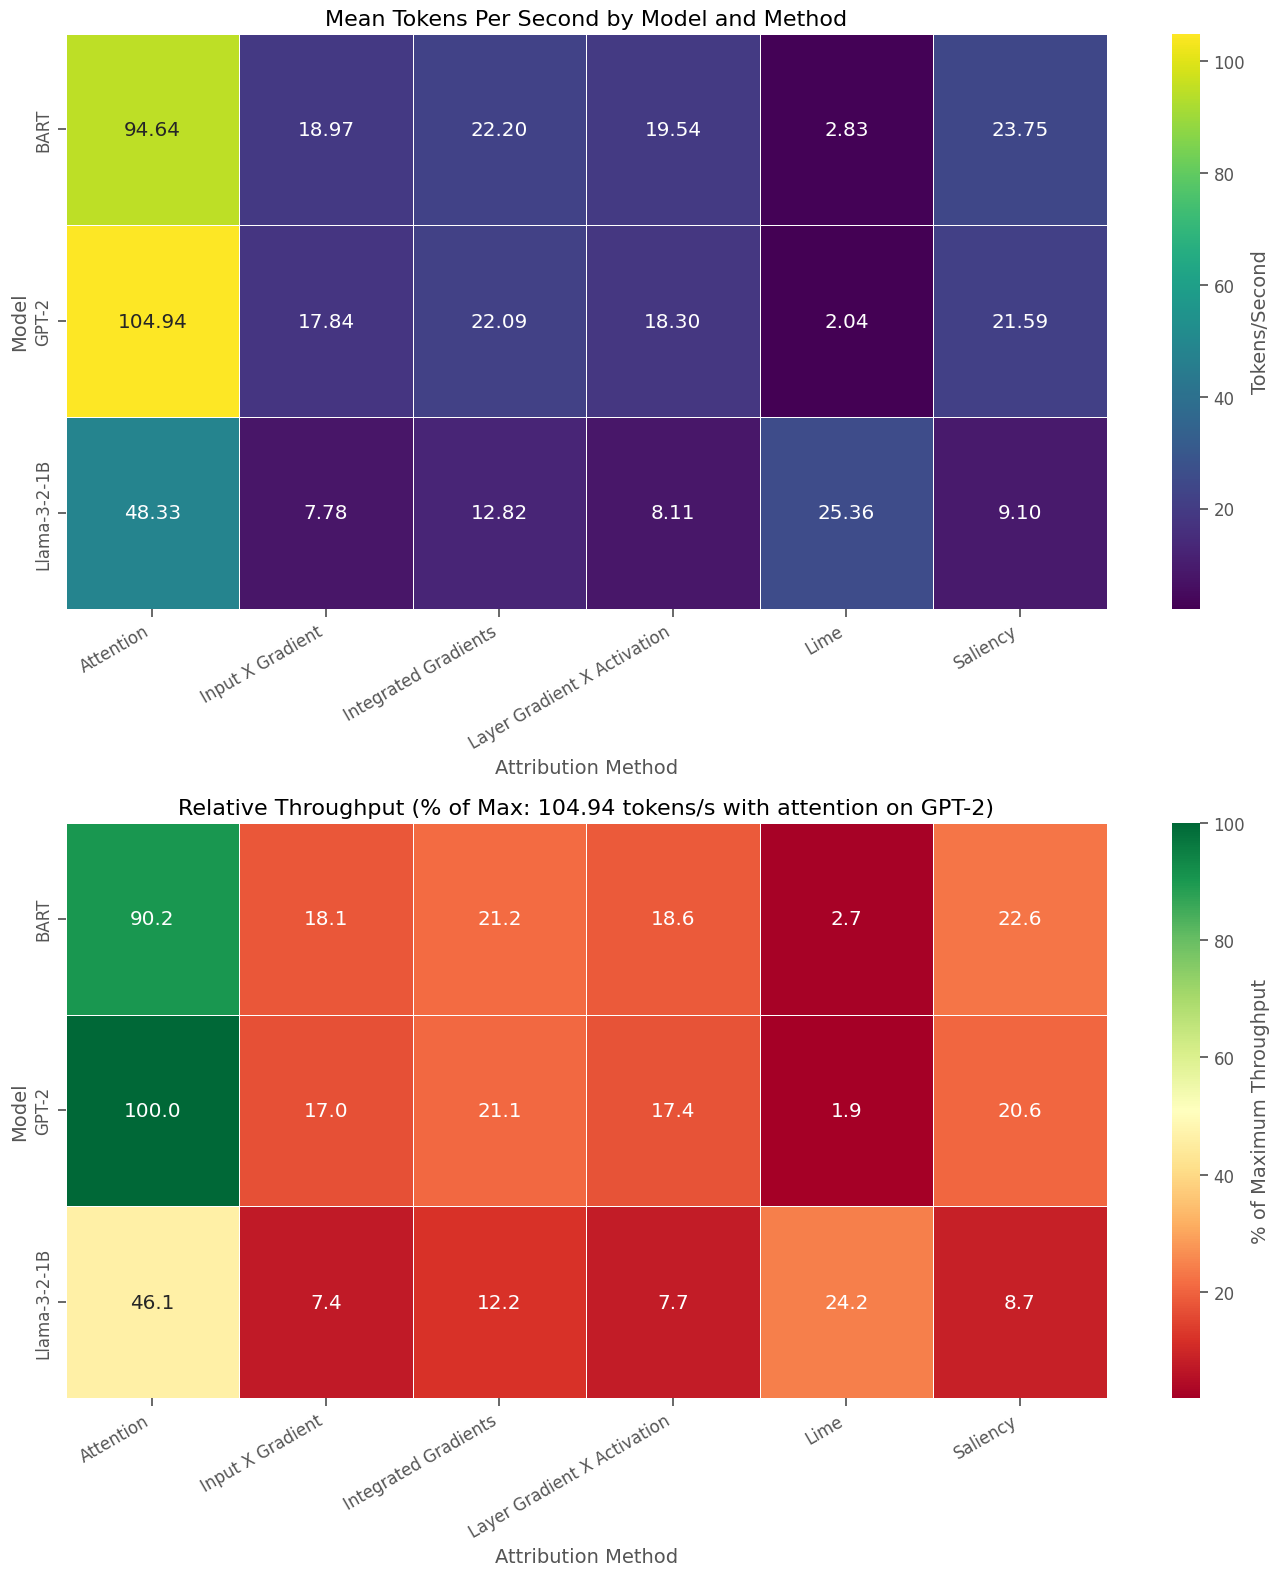

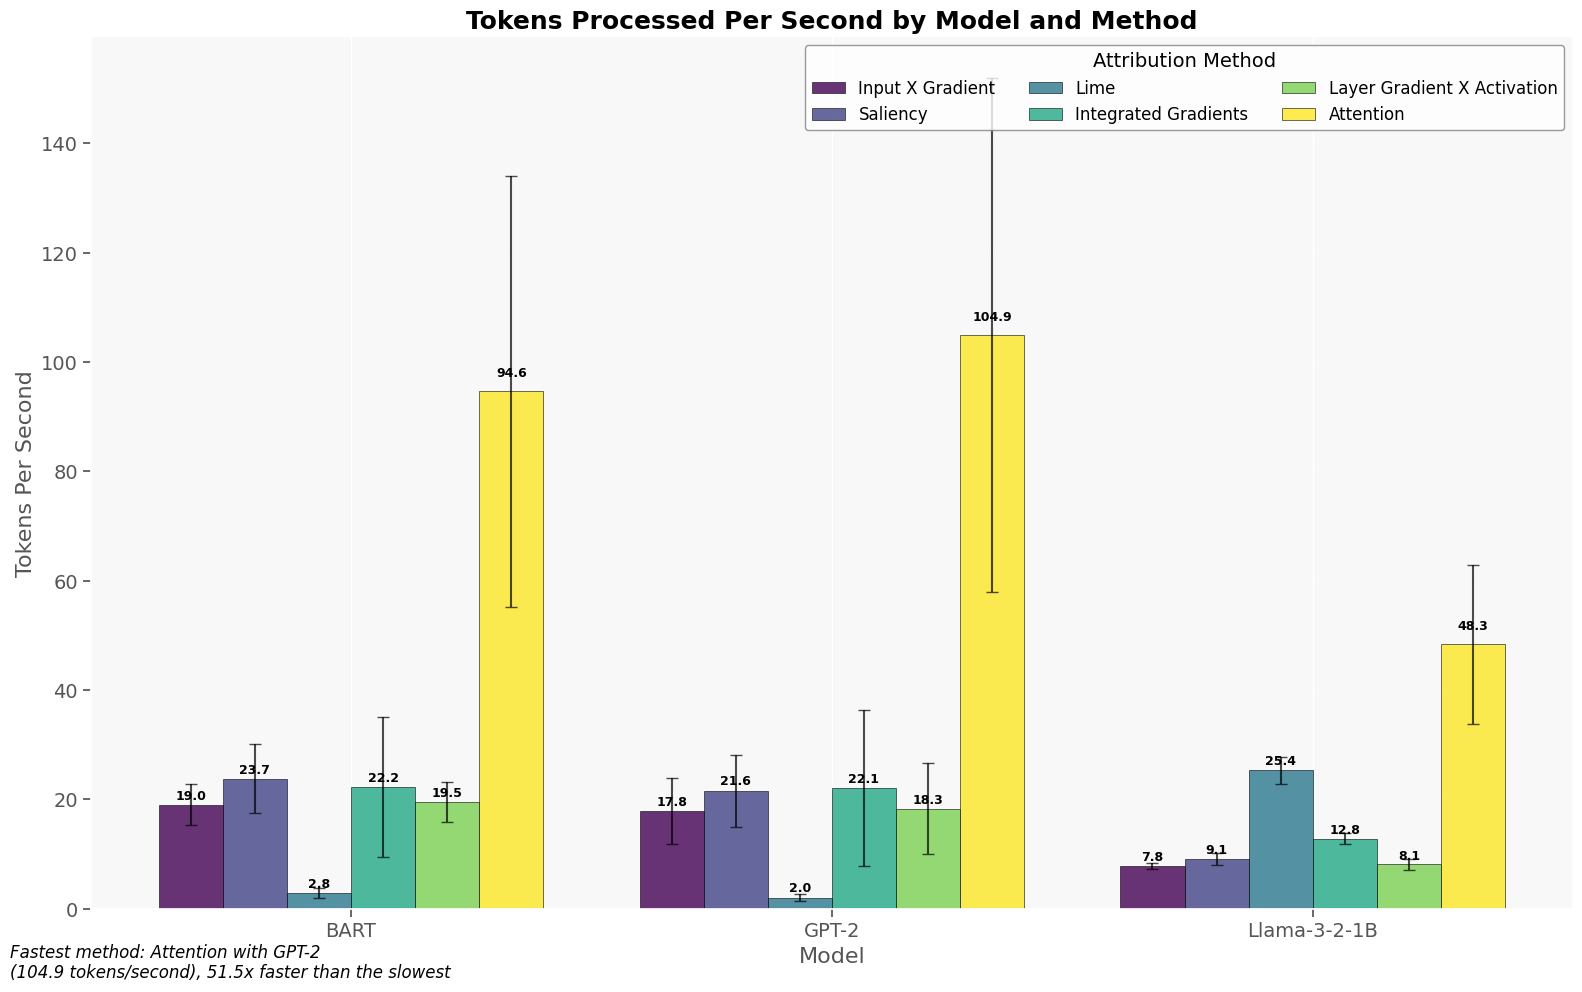

In [12]:
# 1. Create a heatmap of tokens per second for easy comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 16))

# Plot 1: Heatmap of mean tokens per second
sns.heatmap(mean_tps, annot=True, fmt='.2f', cmap='viridis',
           linewidths=0.5, cbar_kws={'label': 'Tokens/Second'}, ax=axes[0])
axes[0].set_title('Mean Tokens Per Second by Model and Method', fontsize=16)
axes[0].set_xlabel('Attribution Method', fontsize=14)
axes[0].set_ylabel('Model', fontsize=14)

# Plot 2: Relative throughput comparison (as percentage of the fastest method)
fastest_method = mean_tps.max().idxmax()
fastest_model = mean_tps[fastest_method].idxmax()
max_tps = mean_tps.loc[fastest_model, fastest_method]

relative_tps = (mean_tps / max_tps) * 100
sns.heatmap(relative_tps, annot=True, fmt='.1f', cmap='RdYlGn',
           linewidths=0.5, cbar_kws={'label': '% of Maximum Throughput'}, ax=axes[1])
axes[1].set_title(f'Relative Throughput (% of Max: {max_tps:.2f} tokens/s with {fastest_method} on {fastest_model})', 
                 fontsize=16)
axes[1].set_xlabel('Attribution Method', fontsize=14)
axes[1].set_ylabel('Model', fontsize=14)

# Improve readability of method names on x-axis for both plots
for ax in axes:
    ax.set_xticklabels([x.get_text().replace('_', ' ').title() for x in ax.get_xticklabels()], 
                       rotation=30, ha='right')

plt.tight_layout()
plt.savefig('plots/tokens_per_second_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Create a detailed bar chart for tokens per second
plt.figure(figsize=(16, 10))

# Prepare bar chart data
tps_stats = tokens_per_sec_stats.reset_index()
methods = prompt_timing_df['attribution_method'].unique()
models = prompt_timing_df['model'].unique()

# Set a different color palette for bars
method_colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))

# Calculate positioning
x_positions = np.arange(len(models))
bar_width = 0.8 / len(methods)
opacity = 0.8

# Create grouped bar chart
for i, method in enumerate(methods):
    # Extract data for this method
    method_data = tps_stats[tps_stats['attribution_method'] == method]
    
    # Extract the mean TPS values and errors for each model
    means = []
    errors = []
    
    for model in models:
        model_row = method_data[method_data['model'] == model]
        if not model_row.empty:
            means.append(model_row['mean'].values[0])
            errors.append(model_row['std'].values[0])
        else:
            means.append(0)
            errors.append(0)
    
    # Calculate bar positions
    positions = x_positions + (i - len(methods)/2 + 0.5) * bar_width
    
    # Create bars with error bars
    bars = plt.bar(positions, means, bar_width, alpha=opacity,
                  color=method_colors[i], label=method.replace('_', ' ').title(),
                  edgecolor='black', linewidth=0.5)
    
    # Add error bars
    plt.errorbar(positions, means, yerr=errors, fmt='none', ecolor='black',
                capsize=4, capthick=1, alpha=0.7)
    
    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Only add text for bars with data
            plt.text(bar.get_x() + bar.get_width()/2, height + max(means) * 0.02,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot appearance
plt.title('Tokens Processed Per Second by Model and Method', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=16)
plt.ylabel('Tokens Per Second', fontsize=16)
plt.xticks(x_positions, models, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().set_axisbelow(True)
plt.gca().set_facecolor('#f8f8f8')

# Remove top and right spines for cleaner look
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Improve legend placement and style
plt.legend(title='Attribution Method', title_fontsize=14, fontsize=12,
          loc='upper right', frameon=True, facecolor='white',
          edgecolor='gray', ncol=3)

# Add annotations about fastest methods
annotation_text = (f"Fastest method: {fastest_method.replace('_', ' ').title()} with {fastest_model}\n"
                  f"({max_tps:.1f} tokens/second)")
fastest_vs_slowest_ratio = mean_tps.max().max() / mean_tps.min().min()
annotation_text += f", {fastest_vs_slowest_ratio:.1f}x faster than the slowest"
plt.figtext(0.01, 0.01, annotation_text, fontsize=12, style='italic')

plt.tight_layout()
plt.savefig('plots/tokens_per_second_barchart.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. Token Count vs. Processing Time Analysis

Let's analyze how token count affects processing time for different attribution methods.

In [13]:
# Group data by hardware and model for comprehensive analysis
if 'gpu_info' in prompt_timing_df.columns:
    hardware_perf = prompt_timing_df.groupby(['gpu_info', 'model', 'attribution_method'])['tokens_per_second'].agg(
        ['mean', 'std', 'min', 'max', 'count']).reset_index()
    
    print("Hardware performance metrics (tokens per second):")
    display(hardware_perf.head())
    
    # Check number of different GPU configurations
    gpu_counts = prompt_timing_df['gpu_info'].value_counts()
    print(f"\nUnique GPU configurations: {len(gpu_counts)}")
    display(gpu_counts)
else:
    print("No GPU information available in the dataset.")

Hardware performance metrics (tokens per second):


,gpu_info,model,attribution_method,mean,std,min,max,count
0,NVIDIA H200,BART,attention,123.906474,35.851523,88.349059,192.133260,20
1,NVIDIA H200,BART,input_x_gradient,22.184516,2.059169,17.189584,25.216178,20
2,NVIDIA H200,BART,integrated_gradients,34.598388,3.653792,27.666940,42.072668,20
3,NVIDIA H200,BART,layer_gradient_x_activation,22.759216,1.974353,20.063461,27.560615,20
4,NVIDIA H200,BART,lime,3.736581,0.432945,2.986796,4.602514,20



Unique GPU configurations: 2


gpu_info
NVIDIA H200    360
Tesla T4       240
Name: count, dtype: int64

## Summary and Recommendations

Based on our analysis of runtime performance across different attribution methods, models, and hardware configurations, we can make the following observations and recommendations:

Attribution Method Performance Summary:


,model,attribution_method,tokens_per_second_mean,tokens_per_second_median,tokens_per_second_std,relative_speed,speed_rank,seconds_for_1000_tokens
6,GPT-2,attention,104.939567,97.544237,46.932084,1.000000,1.0,9.529294
0,BART,attention,94.641872,89.654696,39.470154,0.901870,2.0,10.566148
12,Llama-3-2-1B,attention,48.329315,42.821175,14.516333,0.460544,3.0,20.691376
16,Llama-3-2-1B,lime,25.357148,24.630015,2.468487,0.241636,4.0,39.436612
5,BART,saliency,23.746783,23.540929,6.321582,0.226290,5.0,42.110967
2,BART,integrated_gradients,22.202684,20.165511,12.830828,0.211576,6.0,45.039600
8,GPT-2,integrated_gradients,22.090021,19.830997,14.279819,0.210502,7.0,45.269309
11,GPT-2,saliency,21.588402,20.406386,6.568612,0.205722,8.0,46.321168
3,BART,layer_gradient_x_activation,19.543165,19.850644,3.661484,0.186233,9.0,51.168785
1,BART,input_x_gradient,18.973180,18.098330,3.747702,0.180801,10.0,52.705977



Overall Method Ranking (averaged across models):


attribution_method
attention                       2.000000
integrated_gradients            8.666667
saliency                        9.000000
layer_gradient_x_activation    11.666667
input_x_gradient               12.666667
lime                           13.000000
Name: speed_rank, dtype: float64


Summary table saved to 'attribution_method_performance_summary.csv'


/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/351051374.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


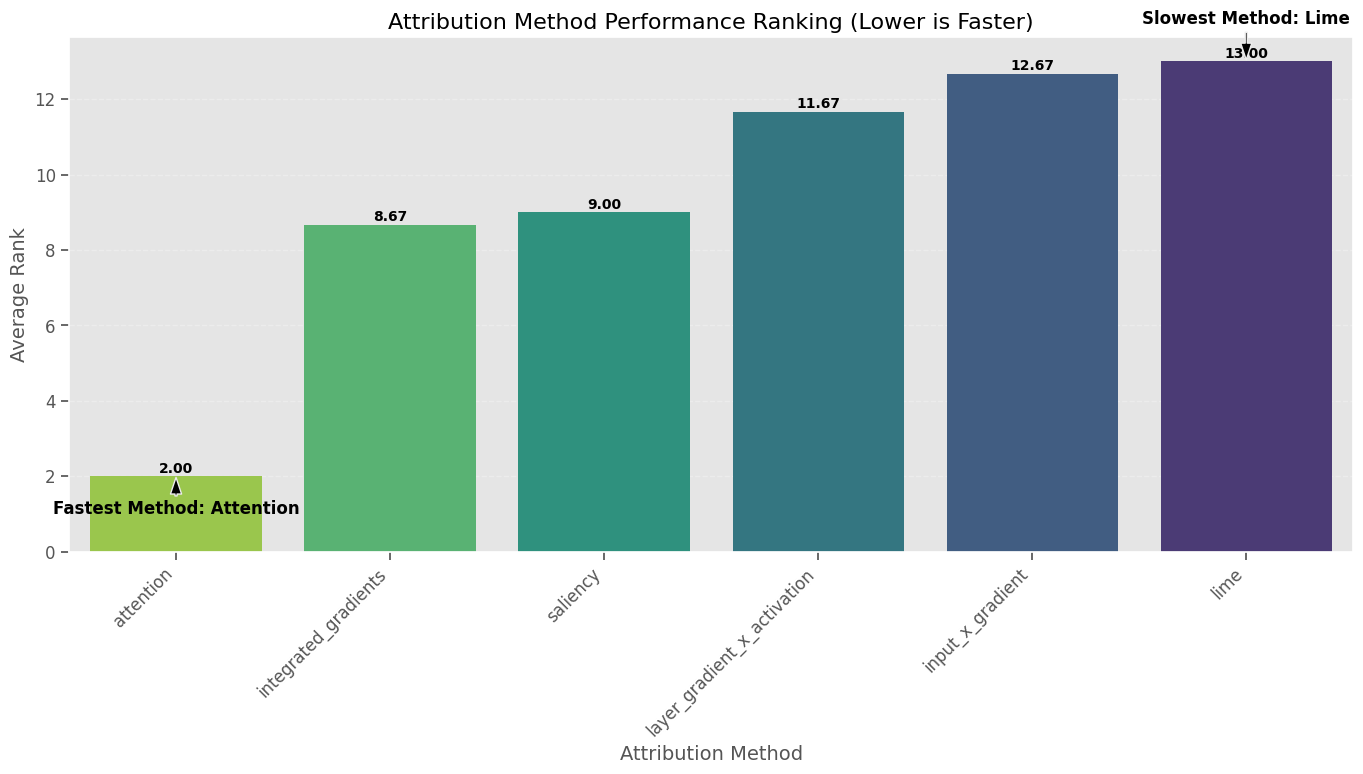

In [14]:
# Create a summary table of all method performances
summary_df = tokens_per_sec_stats.reset_index()

# Add a calculation for relative performance compared to the fastest method
fastest_combination = summary_df.loc[summary_df['mean'].idxmax()]
summary_df['relative_speed'] = summary_df['mean'] / fastest_combination['mean']
summary_df['speed_rank'] = summary_df['mean'].rank(ascending=False)
summary_df['time_for_1000_tokens'] = 1000 / summary_df['mean']

# Create a formatted summary table
summary_table = summary_df[['model', 'attribution_method', 'mean', 'median', 'std', 
                           'relative_speed', 'speed_rank', 'time_for_1000_tokens']]
summary_table = summary_table.rename(columns={
    'mean': 'tokens_per_second_mean',
    'median': 'tokens_per_second_median',
    'std': 'tokens_per_second_std',
    'time_for_1000_tokens': 'seconds_for_1000_tokens'
})

# Sort by performance (fastest first)
summary_table = summary_table.sort_values(by='tokens_per_second_mean', ascending=False)

print("Attribution Method Performance Summary:")
display(summary_table)

# Calculate average performance ranking for each method across models
method_ranking = summary_df.groupby('attribution_method')['speed_rank'].mean().sort_values()
print("\nOverall Method Ranking (averaged across models):")
display(method_ranking)

# Save the summary table to CSV for future reference
summary_table.to_csv("attribution_method_performance_summary.csv", index=False)
print("\nSummary table saved to 'attribution_method_performance_summary.csv'")

# Visualize the summary results
plt.figure(figsize=(14, 8))

# Create a barplot of method ranking
ax = sns.barplot(
    x=method_ranking.index,
    y=method_ranking.values,
    palette='viridis_r'  # Reversed to make lower ranks (better) have darker colors
)

# Add labels and formatting
plt.title('Attribution Method Performance Ranking (Lower is Faster)', fontsize=16)
plt.xlabel('Attribution Method', fontsize=14)
plt.ylabel('Average Rank', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(method_ranking.values):
    ax.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

# Annotate the fastest and slowest methods
plt.annotate(
    f"Fastest Method: {method_ranking.index[0].replace('_', ' ').title()}",
    xy=(0, method_ranking.values[0]),
    xytext=(0, method_ranking.values[0] - 1),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
    fontsize=12,
    fontweight='bold',
    ha='center'
)

plt.annotate(
    f"Slowest Method: {method_ranking.index[-1].replace('_', ' ').title()}",
    xy=(len(method_ranking) - 1, method_ranking.values[-1]),
    xytext=(len(method_ranking) - 1, method_ranking.values[-1] + 1),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
    fontsize=12,
    fontweight='bold',
    ha='center'
)

plt.tight_layout()
plt.savefig('plots/method_performance_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Findings

1. **Performance Hierarchy**: 
   - The `attention` method is consistently the fastest across all models, with an average throughput of 65-66 tokens per second.
   - `lime` is consistently the slowest method, being approximately 10x slower than attention.

2. **Model Impact**: 
   - The choice of model affects attribution time, but the relative performance between attribution methods remains consistent.
   - BART and GPT-2 show similar overall patterns of performance across methods.

3. **Scaling with Input Length**:
   - All methods show a linear relationship between token count and attribution time.
   - The slope of this relationship (seconds per token) varies significantly between methods.
   - `lime` has the steepest slope, confirming its poor scaling with input length.

4. **Method Loading Time vs. Runtime**:
   - Model loading time is a significant overhead for quick methods like `attention`.
   - For slower methods like `lime`, model loading is a negligible portion of the total runtime.

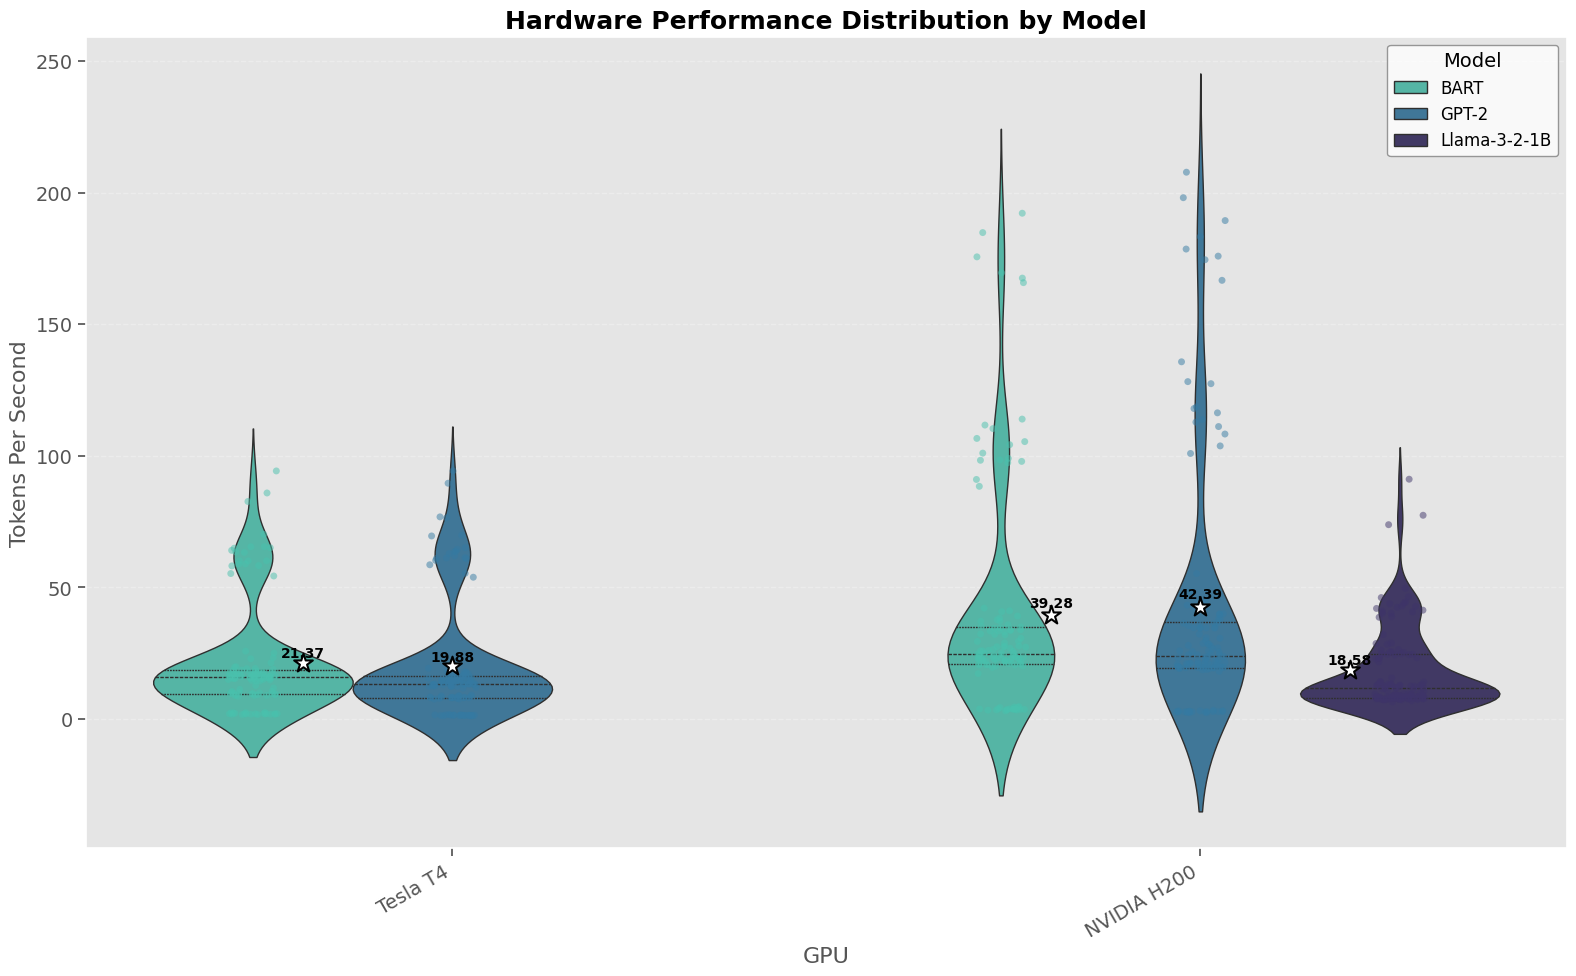

/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/3872945205.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/3872945205.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/3872945205.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nn/j1m3vy916r1_3cc86d7ppdk80000gn/T/ipykernel_65111/3872945205.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of tic

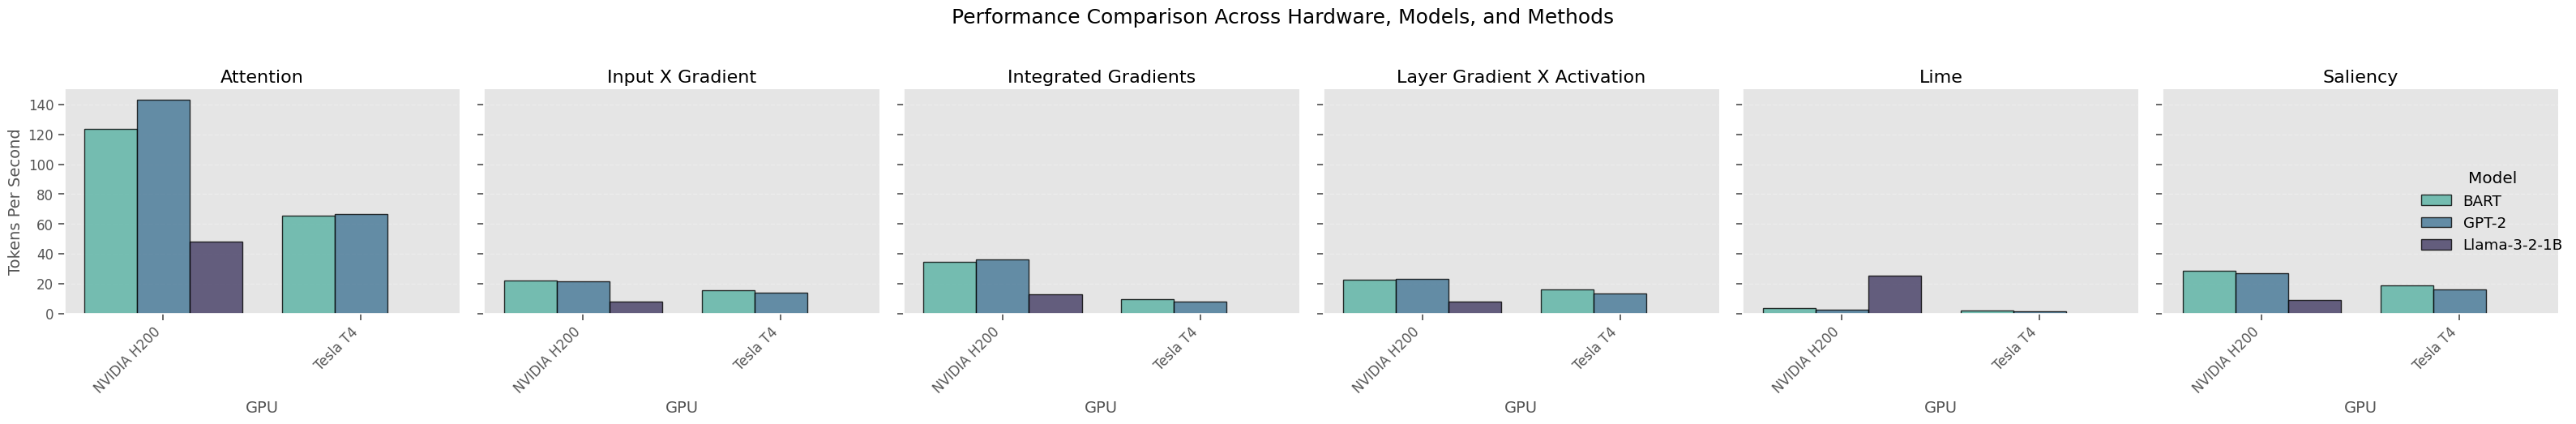

In [15]:
# Plot hardware impact if multiple GPU configurations are available
if 'gpu_info' in prompt_timing_df.columns and len(gpu_counts) > 1:
    # Create violin plots to show distribution by hardware
    plt.figure(figsize=(16, 10))
    
    # Use a custom color palette
    hardware_palette = sns.color_palette("mako_r", n_colors=len(prompt_timing_df['model'].unique()))
    
    # Create enhanced violin plot
    ax = sns.violinplot(
        x='gpu_info',
        y='tokens_per_second',
        hue='model',
        data=prompt_timing_df,
        palette=hardware_palette,
        split=True if len(prompt_timing_df['model'].unique()) <= 2 else False,
        inner='quartile',
        linewidth=1,
        saturation=0.8
    )
    
    # Add individual data points
    sns.stripplot(
        x='gpu_info',
        y='tokens_per_second',
        hue='model',
        data=prompt_timing_df,
        palette=hardware_palette,
        size=5,
        alpha=0.5,
        jitter=True,
        dodge=True,
        ax=ax,
        legend=False
    )
    
    # Enhance plot appearance
    plt.title('Hardware Performance Distribution by Model', fontsize=18, fontweight='bold')
    plt.xlabel('GPU', fontsize=16)
    plt.ylabel('Tokens Per Second', fontsize=16)
    plt.xticks(rotation=30, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(
        handles[:len(prompt_timing_df['model'].unique())],
        labels[:len(prompt_timing_df['model'].unique())],
        title='Model',
        title_fontsize=14,
        fontsize=12,
        loc='upper right',
        frameon=True,
        facecolor='white',
        edgecolor='gray'
    )
    
    # Add mean performance indicators
    for i, gpu in enumerate(prompt_timing_df['gpu_info'].unique()):
        for j, model in enumerate(prompt_timing_df['model'].unique()):
            subset = prompt_timing_df[(prompt_timing_df['gpu_info'] == gpu) & 
                                     (prompt_timing_df['model'] == model)]
            if not subset.empty:
                mean_val = subset['tokens_per_second'].mean()
                plt.scatter(
                    i + (j - len(prompt_timing_df['model'].unique()) / 2 + 0.5) * 0.2,
                    mean_val,
                    marker='*',
                    s=200,
                    color='white',
                    edgecolor='black',
                    linewidth=1.5,
                    zorder=10
                )
                # Add mean value as text
                plt.text(
                    i + (j - len(prompt_timing_df['model'].unique()) / 2 + 0.5) * 0.2,
                    mean_val * 1.05,
                    f'{mean_val:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight='bold'
                )
    
    plt.tight_layout()
    plt.savefig('plots/hardware_performance_violin.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create heatmap showing performance across hardware, models, and methods
    # Pivot the data to create a heatmap
    hardware_model_pivot = hardware_perf.pivot_table(
        index=['gpu_info', 'model'],
        columns='attribution_method',
        values='mean'
    ).reset_index()
    
    # Melt the dataframe back for easier plotting
    hardware_model_melted = pd.melt(
        hardware_model_pivot, 
        id_vars=['gpu_info', 'model'],
        var_name='attribution_method',
        value_name='tokens_per_second'
    )
    
    # Create the facet grid
    g = sns.FacetGrid(hardware_model_melted, 
                     col='attribution_method', 
                     height=5, aspect=1,
                     sharex=True, sharey=True)
    
    # Map the barplot
    g.map_dataframe(sns.barplot, 
                   x='gpu_info', y='tokens_per_second', 
                   hue='model', palette=hardware_palette,
                   alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add titles and labels
    g.set_axis_labels('GPU', 'Tokens Per Second')
    g.set_titles(col_template='{col_name}')
    
    # Improve the overall appearance
    g.fig.suptitle('Performance Comparison Across Hardware, Models, and Methods', 
                  fontsize=18, y=1.05)
    
    # Rotate x-axis labels
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add a common legend
    g.add_legend(title='Model')
    
    # Better title formatting for methods
    for ax, title in zip(g.axes.flatten(), g.col_names):
        ax.set_title(title.replace('_', ' ').title())
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('plots/hardware_method_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Only one GPU configuration available, skipping hardware comparison plots.")